<a href="https://colab.research.google.com/github/luca-nassano/ChestXRAY/blob/master/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
tf.random.set_seed(42)

In [0]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser)
  parsed_dataset = parsed_dataset.map(normalize_image)
  return parsed_dataset

batch_size = 64
train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

Link cartella Drive contenente i modelli trainati: https://drive.google.com/open?id=1EkuS27OzYyQ4fqfiNQdcrO6nQkyKBJ9B

In [0]:
from tensorflow.keras.models import load_model

base_path = '/content/drive/My Drive/Models'
def load_models(base_path):
  models = []
  for model in os.listdir(base_path):
    print('loading model: {}'.format(model))
    models.append(load_model(os.path.join(base_path,model)))
  return models

models = load_models(base_path)

loading model: inceptionresnetv2_model.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


loading model: xception_model.hdf5
loading model: densenet121_model.hdf5
loading model: densenet169_model.hdf5
loading model: densenet201_model.hdf5
loading model: vgg19_model.hdf5
loading model: vgg16_model.hdf5


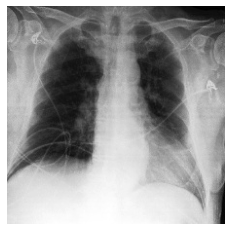

In [0]:
unbatched_test = test_dataset.unbatch()
test_imgs = []
test_labels = []
for img, labels in unbatched_test:
  test_imgs.append(img.numpy())
  test_labels.append(labels.numpy())
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

def get_img(index):
  return test_imgs[index].reshape(-1,224,224,3)

img_index = 0

img = get_img(img_index)
plt.imshow(img[0,:,:,0],cmap='gray')
plt.axis('off')

In [0]:
import cv2
last_conv_name = ['conv_7b_bn','block14_sepconv2_bn','bn','bn','bn','block5_pool','block5_pool','block5_pool']

def compute_cams(models,img,label):
  cams = []
  for i,model in enumerate(models):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_name[i]).output, model.output])
   
    with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(np.array([img[0]]))
      loss = predictions[:,label]
      grads = tape.gradient(loss, conv_outputs)[0]

    output = conv_outputs[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = (cam-np.mean(cam))/np.std(cam)
    cams.append(cam)
  return cams
  


In [0]:
label = 2
cams = compute_cams(models,img,label)
cam = np.average(cams,axis=0)

(-0.5, 223.5, 223.5, -0.5)

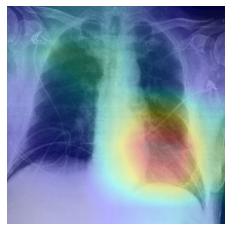

In [0]:
plt.imshow(img[0,:,:,0],alpha=1,cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.3)
plt.axis('off')

In [0]:
mask = cam >= 0.5*np.max(cam)
bbox = img[0,:,:,0]*mask

(-0.5, 223.5, 223.5, -0.5)

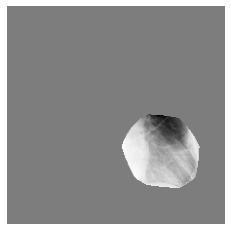

In [0]:
plt.imshow(bbox,cmap='gray')
plt.axis('off')

In [0]:
x_min = np.min(np.argwhere(bbox > 0)[:,1])
x_max = np.max(np.argwhere(bbox > 0)[:,1])
y_min = np.min(np.argwhere(bbox > 0)[:,0])
y_max = np.max(np.argwhere(bbox > 0)[:,0])

In [0]:
pt1 = x_min,y_min
pt2 = x_max,y_max

In [0]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
img = (img * imagenet_std) + imagenet_mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

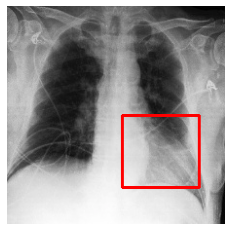

In [0]:
plt.imshow(cv2.rectangle(img[0,:,:,:], pt1, pt2, (255,0,0), thickness=2))
plt.axis('off')
